In [32]:
import copy
import os
import sys
import time

sys.path.append('..')

from src.experiments.register import *
from src.experiments.argument_handling import *
from src.envs.creation import make_env, create_simple_gridworld_env
from src.envs.simulation import *
from src.envs.wrappers import *
from src.utils.constants import *
from src.agents import *
from src.agents.base import *
from src.agents.exploration import *
from src.models.base import *

import einops
import gym
from gym import ObservationWrapper
from gym.wrappers import TimeLimit
from gym_gridworld.envs.gridworld_env import GridworldEnv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm

os.environ['WANDB_SILENT'] = 'true'
wandb.init()

%matplotlib inline

In [33]:
class TimeAddedWrapper(ObservationWrapper):
  def __init__(self, env):
    super(TimeAddedWrapper, self).__init__(env)
    self.time_added = 0

  def observation(self, observation):
    time_frac = self.env._elapsed_steps / self.env._max_episode_steps
    observation[0, 0, 0] += time_frac
    return observation

def create_env(randomized=False, max_steps=100, map_shape=(16, 16), goal_termination=True):
  global N_FRAME_STACK
  N_FRAME_STACK = 1

  env = gym.make('gridworld-v0')
  env = GridWorldWrapper(env)
  if not goal_termination:
    env = NoTerminationWrapper(env)
  env = SimpleMapWrapper(env, randomized, map_shape)
  if max_steps > 0:
    env = TimeLimit(env, max_steps)
    env = TimeAddedWrapper(env)
  env = TransformObservation(env, torch.FloatTensor)
  return env

# explore_env = \
#   RandomTerminationWrapper(
#     NoTerminationWrapper(
#       NoRewardWrapper(
#         make_env('Gridworld'))), 0.005)

In [34]:
# Adapted from: https://github.com/deepmind/deepmind-research/blob/master/visr/VISR_ICLR2020.ipynb
def sample_sphere(dim, n=1):
  unnormed = np.random.randn(n, dim)
  arr = unnormed / np.linalg.norm(unnormed, axis=-1, keepdims=True)
  return torch.FloatTensor(arr)
  
def sample_batch(buffer, n):
  data_idxs = np.random.choice(range(len(buffer)), size=n, replace=False)
  batch_data = []
  for i in data_idxs:
    batch_data.append(buffer[i])
  return batch_data

def sample_recent_batch(buffer, n):
  return buffer[-n:]

# Creates a state where the agent is in a random position
def generate_random_state(env):
    valid_state = False
    while not valid_state:
        state = [np.random.randint(0, env.unwrapped.grid_map_shape[0]), \
                 np.random.randint(0, env.unwrapped.grid_map_shape[1])]
        # If location is empty or goal state
        if env.unwrapped.current_grid_map[state[0], state[1]] in (0, 3):
            valid_state = True
    obs, _, _, _ = copy.deepcopy(env).jump_to_state(state)
    return env.observation(obs)

In [35]:
class FeatureNetwork(nn.Module):
    def __init__(self, obs_dim, n_acts, embed_dim=256, encoder=None):
        super().__init__()
        
        self.n_acts = n_acts
        self.embed_dim = embed_dim

        if encoder is None:
            f_encoder = create_encoder_from_obs_dim(obs_dim)
            sf_encoder = create_encoder_from_obs_dim(obs_dim)

        test_input = torch.zeros(1, *obs_dim)
        with torch.no_grad():
            self.encoder_output_size = f_encoder(test_input).view(-1).shape[0]
        hidden_size = get_hidden_size_from_obs_dim(obs_dim)
        
        # Feature layers
        self.f_encoder = nn.Sequential(
            f_encoder,
            nn.Flatten(),
            nn.Linear(self.encoder_output_size, hidden_size))

        self.feature_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_dim))

        # Successor Feature layers
        self.sf_encoder = nn.Sequential(
            sf_encoder,
            nn.Flatten(),
            nn.Linear(self.encoder_output_size, hidden_size))

        self.sf_layers = nn.Sequential(
            nn.Linear(hidden_size+embed_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            # TODO: Try different output layer for each cumulant
            nn.Linear(hidden_size, n_acts * embed_dim))

    def forward(self, x, goal_vector=None):
        embeds = self.f_encoder(x)
        features = self.feature_layers(embeds)
        features = F.normalize(features, dim=1)

        if goal_vector is None:
            return features, None

        embeds = self.sf_encoder(x)
        sf_input = torch.cat([embeds, goal_vector], dim=-1)
        sfs = self.sf_layers(sf_input)
        sfs = sfs.reshape(-1, self.n_acts, self.embed_dim)

        return features, sfs

    # TODO: Add a target network for sfs
    def train(self, batch_data, optimizer, gamma=0.99, reward_loss_weight=10):
        device = next(self.parameters()).device

        batch_data = np.array(batch_data)
        obs, acts, next_obs, rewards, dones, skill_vectors = \
            [torch.from_numpy(np.stack(batch_data[:, i])).to(device) \
            for i in range(batch_data.shape[1])]

        _, next_sfs = self(next_obs, skill_vectors)
        features, sfs = self(obs, skill_vectors)
        
        next_q_vals = torch.bmm(next_sfs, skill_vectors.unsqueeze(2))
        next_acts = next_q_vals.argmax(dim=1).unsqueeze(-1).repeat(1, 1, next_sfs.shape[2]).long()
        selected_next_sfs = next_sfs.gather(dim=1, index=next_acts)
        selected_next_sfs = selected_next_sfs.squeeze(1)
        terminals = 1 - dones.int()
        y = features + gamma * selected_next_sfs * terminals.unsqueeze(1)

        sf_idxs = acts.unsqueeze(1).unsqueeze(2).repeat(1, 1, sfs.shape[2]).long()
        selected_sfs = sfs.gather(dim=1, index=sf_idxs)
        selected_sfs = selected_sfs.squeeze(1)

        td_loss = (y.detach() - selected_sfs) ** 2
        td_loss = torch.mean(torch.sum(td_loss, dim=1))

        reward_loss = 1.0 - torch.bmm(features.unsqueeze(1), skill_vectors.unsqueeze(2))
        reward_loss = reward_loss.mean()

        total_loss = reward_loss_weight * reward_loss + td_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        return total_loss, reward_loss, td_loss

In [54]:
class SimpleFeatureNetwork(nn.Module):
    def __init__(self, obs_dim, n_acts, embed_dim=256, encoder=None):
        super().__init__()
        
        self.n_acts = n_acts
        self.embed_dim = embed_dim

        self.feature_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(obs_dim), 100),
            nn.ReLU(),
            nn.Linear(100, embed_dim))

        self.sf_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(obs_dim) + embed_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, embed_dim * n_acts))

    def forward(self, x, goal_vector=None):
        features = self.feature_layers(x)
        features = F.normalize(features, dim=1)

        if goal_vector is None:
            return features, None

        sf_input = torch.cat([x.view(x.shape[0], -1), goal_vector], dim=-1)
        sfs = self.sf_layers(sf_input)
        sfs = sfs.view(-1, self.n_acts, self.embed_dim)

        return features, sfs

    def train(self, batch_data, optimizer, gamma=0.99, reward_loss_weight=10, target_model=None):
        device = next(self.parameters()).device

        batch_data = np.array(batch_data)
        obs, acts, next_obs, rewards, dones, skill_vectors = \
            [torch.from_numpy(np.stack(batch_data[:, i])).to(device) \
            for i in range(batch_data.shape[1])]

        if target_model:
            _, next_sfs = target_model(next_obs, skill_vectors)
        else:
            _, next_sfs = self(next_obs, skill_vectors)
        features, sfs = self(obs, skill_vectors)

        next_q_vals = torch.bmm(next_sfs, skill_vectors.unsqueeze(2))
        next_acts = next_q_vals.argmax(dim=1).unsqueeze(-1).repeat(1, 1, next_sfs.shape[2]).long()
        selected_next_sfs = next_sfs.gather(dim=1, index=next_acts)
        selected_next_sfs = selected_next_sfs.squeeze(1)
        terminals = 1 - dones.int()
        y = features + gamma * selected_next_sfs * terminals.unsqueeze(1)

        sf_idxs = acts.unsqueeze(1).unsqueeze(2).repeat(1, 1, sfs.shape[2]).long()
        selected_sfs = sfs.gather(dim=1, index=sf_idxs)
        selected_sfs = selected_sfs.squeeze(1)

        td_loss = (y.detach() - selected_sfs) ** 2
        td_loss = td_loss.mean()

        reward_loss = 1.0 - torch.bmm(features.unsqueeze(1), skill_vectors.unsqueeze(2))
        reward_loss = reward_loss.mean()

        if reward_loss_weight > 0:
            total_loss = reward_loss_weight * reward_loss + td_loss
        else:
            total_loss = td_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        return total_loss, reward_loss, td_loss

# Training

In [55]:
DEVICE = 'cpu'

n_episodes = 100000
update_freq = 40
batch_size = 40
print_freq = update_freq * 500
max_steps = 40
randomize_env = False
exp_buffer_size = int(1e6)
gamma = 0.95
map_shape = (10, 10)
target_update_freq = 500 # In number of updates
gpi_steps = 10

start_act_epsilon = 0.1
end_act_epsilon = 0.1
act_epsilon_anneal_steps = int(1e4)

start_reward_weight = 10
end_reward_weight = 10
reward_anneal_steps = int(1e5)

embed_dim = 5
lr = 1e-4


def anneal_func(step, start, end, n_steps):
  if step >= n_steps:
    return end
  return start - ((start - end) * (step / n_steps))

get_act_epsilon = lambda step: anneal_func(
    step, start_act_epsilon, end_act_epsilon, act_epsilon_anneal_steps)
get_reward_weight = lambda step: anneal_func(
    step, start_reward_weight, end_reward_weight, reward_anneal_steps)

In [56]:
explore_env = create_env(randomize_env, max_steps, map_shape, False)

obs_dim = explore_env.observation_space.shape
n_acts = explore_env.action_space.n
model = SimpleFeatureNetwork(obs_dim, n_acts, embed_dim)
model = model.to(DEVICE)
target_model = copy.deepcopy(model)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-5)

sample_skill = lambda: sample_sphere(embed_dim)[0]

exp_buffer = [] # [[obs, act, next_obs, reward, done, skill_vector], ...]

all_rewards = []
loss_hist = [[], [], []]
mc_error_hist = [] # Monte-Carlo SF MSE
step_idx = 0

In [57]:
# Episode loop
episodes_passed = 0
n_updates = 0
for episode_idx in range(n_episodes):
  obs = explore_env.reset()

  skill_vector = sample_skill()

  with torch.no_grad():
    ep_real_sfs, ep_pred_sfs = model(
        obs.unsqueeze(0).to(DEVICE), 
        skill_vector.unsqueeze(0).to(DEVICE))
  ep_real_sfs, ep_pred_sfs = ep_real_sfs[0], ep_pred_sfs[0]

  ep_rewards = []
  done = False
  ep_step_idx = 0
  while not done:
    # Sample an action
    if np.random.rand() < get_act_epsilon(step_idx):
      # Random sample
      act = explore_env.action_space.sample()
    else:
      if gpi_steps > 1:
        # Sample based off of successor features using with GPI
        skill_vectors = [skill_vector] + [sample_skill() for _ in range(gpi_steps)]
        skill_vectors = torch.stack(skill_vectors, dim=0).to(DEVICE)
        with torch.no_grad():
          _, sfs = model(torch.stack((gpi_steps+1)*[obs], dim=0).to(DEVICE),
                         skill_vectors)
        sfs = sfs.cpu()
        q_vals = torch.bmm(sfs, torch.stack((gpi_steps+1)*[skill_vector], dim=0).unsqueeze(2)).squeeze()
        act = torch.argmax(q_vals.view(-1)) % q_vals.shape[1]
      else:
        # Sample based off of successor features
        with torch.no_grad():
          _, sfs = model(obs.unsqueeze(0).to(DEVICE),
                         skill_vector.unsqueeze(0).to(DEVICE))
        sfs = sfs.cpu()
        q_vals = torch.matmul(sfs[0], skill_vector.unsqueeze(1)).squeeze()
        act = torch.argmax(q_vals).item()

    # Select the sfs for the action that was taken
    # This is just used for metrics later
    if ep_step_idx == 0:
      ep_pred_sfs = ep_pred_sfs[act]

    # Take a step
    next_obs, reward, done, _ = explore_env.step(act)
    exp_buffer.append([np.array(copy.deepcopy(obs)), act,
                       np.array(copy.deepcopy(next_obs)),
                       reward, done, np.array(copy.deepcopy(skill_vector))])
    ep_rewards.append(reward)
    obs = next_obs
    
    # Update real sfs for the episode later used for metrics
    with torch.no_grad():
      features = model(obs.unsqueeze(0).to(DEVICE))[0][0]
    ep_real_sfs += features * gamma ** (ep_step_idx + 1)

    # Delete extra data from the experience buffer
    exp_buffer_overflow = len(exp_buffer) - exp_buffer_size
    if exp_buffer_overflow > 0:
      exp_buffer = exp_buffer[-int(0.9*exp_buffer_size):]
    
    # Update the model
    # if step_idx % update_freq == 0 and len(exp_buffer) >= batch_size:
      # batch_data = sample_batch(exp_buffer, batch_size)
    if done:
      batch_data = sample_recent_batch(exp_buffer, update_freq)
      loss, reward_loss, td_loss = model.train(
          batch_data, optimizer, reward_loss_weight=get_reward_weight(step_idx),
          gamma=gamma, target_model=target_model)
      for i, l in enumerate([loss, reward_loss, td_loss]):
        loss_hist[i].append(l.item())
      batch_data = []
      n_updates += 1

      if n_updates % target_update_freq == 0:
        target_model = copy.deepcopy(model)

    # Print the agent training status
    if step_idx > 0 and step_idx % print_freq == 0:
      lookback = print_freq // update_freq
      print('Step: {}\tLoss: {:.4f}\tReward Loss: {:.4f}\tTD Loss: {:.4f}\tMC SF Error: {:.4f}\tEx Reward: {:.2f}'
        .format(step_idx, *[np.mean(loss_hist[i][-lookback:]) \
                            for i in range(len(loss_hist))],
                np.mean(mc_error_hist[-episodes_passed:]),
                np.mean(all_rewards[-episodes_passed:])))
      episodes_passed = 0
    
    step_idx += 1
    ep_step_idx += 1

  # TODO: Calculate this for every step
  sf_pred_mse = torch.mean((ep_pred_sfs - ep_real_sfs) ** 2).item()
  mc_error_hist.append(sf_pred_mse)
  episodes_passed += 1
  all_rewards.append(sum(ep_rewards))

<ipython-input-54-ab713fb06620>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_data = np.array(batch_data)


Step: 20000	Loss: 10.0398	Reward Loss: 0.9962	TD Loss: 0.0774	MC SF Error: 57.3826	Ex Reward: 0.01
Step: 40000	Loss: 9.8239	Reward Loss: 0.9798	TD Loss: 0.0258	MC SF Error: 50.7148	Ex Reward: 0.02
Step: 60000	Loss: 9.7328	Reward Loss: 0.9679	TD Loss: 0.0540	MC SF Error: 48.8418	Ex Reward: 0.02
Step: 80000	Loss: 6.6800	Reward Loss: 0.6494	TD Loss: 0.1860	MC SF Error: 47.0964	Ex Reward: 0.01
Step: 100000	Loss: 5.6983	Reward Loss: 0.5487	TD Loss: 0.2115	MC SF Error: 44.4869	Ex Reward: 0.01
Step: 120000	Loss: 5.4924	Reward Loss: 0.5233	TD Loss: 0.2592	MC SF Error: 44.3343	Ex Reward: 0.01
Step: 140000	Loss: 5.4502	Reward Loss: 0.5063	TD Loss: 0.3868	MC SF Error: 41.6972	Ex Reward: 0.01
Step: 160000	Loss: 5.3987	Reward Loss: 0.4932	TD Loss: 0.4670	MC SF Error: 39.4264	Ex Reward: 0.01
Step: 180000	Loss: 5.4955	Reward Loss: 0.4956	TD Loss: 0.5393	MC SF Error: 39.0077	Ex Reward: 0.02
Step: 200000	Loss: 5.5087	Reward Loss: 0.4902	TD Loss: 0.6069	MC SF Error: 37.3073	Ex Reward: 0.01
Step: 220000	

KeyboardInterrupt: 

In [ ]:
# Step: 20000	Loss: 9.9526	Reward Loss: 0.9880	TD Loss: 0.0725	MC SF Error: 57.4083	Ex Reward: 0.02
# Step: 40000	Loss: 9.4065	Reward Loss: 0.9387	TD Loss: 0.0195	MC SF Error: 50.4786	Ex Reward: 0.01
# Step: 60000	Loss: 8.1938	Reward Loss: 0.8048	TD Loss: 0.1459	MC SF Error: 47.8892	Ex Reward: 0.01
# Step: 80000	Loss: 6.5390	Reward Loss: 0.6367	TD Loss: 0.1722	MC SF Error: 44.4449	Ex Reward: 0.01
# Step: 100000	Loss: 6.2017	Reward Loss: 0.5987	TD Loss: 0.2147	MC SF Error: 43.3388	Ex Reward: 0.01
# Step: 120000	Loss: 5.9788	Reward Loss: 0.5683	TD Loss: 0.2958	MC SF Error: 40.9765	Ex Reward: 0.00
# Step: 140000	Loss: 5.9726	Reward Loss: 0.5571	TD Loss: 0.4017	MC SF Error: 38.2554	Ex Reward: 0.00
# Step: 160000	Loss: 6.1303	Reward Loss: 0.5638	TD Loss: 0.4920	MC SF Error: 37.4894	Ex Reward: 0.00
# Step: 180000	Loss: 6.1443	Reward Loss: 0.5558	TD Loss: 0.5862	MC SF Error: 35.3755	Ex Reward: 0.00
# Step: 200000	Loss: 6.2427	Reward Loss: 0.5550	TD Loss: 0.6924	MC SF Error: 35.5315	Ex Reward: 0.00
# Step: 220000	Loss: 6.3678	Reward Loss: 0.5599	TD Loss: 0.7688	MC SF Error: 33.0670	Ex Reward: 0.00
# Step: 240000	Loss: 6.3795	Reward Loss: 0.5613	TD Loss: 0.7661	MC SF Error: 32.0787	Ex Reward: 0.00
# Step: 260000	Loss: 6.4978	Reward Loss: 0.5725	TD Loss: 0.7730	MC SF Error: 32.1853	Ex Reward: 0.00
# Step: 280000	Loss: 6.2509	Reward Loss: 0.5446	TD Loss: 0.8050	MC SF Error: 30.1279	Ex Reward: 0.01
# Step: 300000	Loss: 6.4819	Reward Loss: 0.5676	TD Loss: 0.8055	MC SF Error: 29.8950	Ex Reward: 0.00
# Step: 320000	Loss: 6.3092	Reward Loss: 0.5496	TD Loss: 0.8130	MC SF Error: 27.6254	Ex Reward: 0.01
# Step: 340000	Loss: 6.3341	Reward Loss: 0.5529	TD Loss: 0.8055	MC SF Error: 29.4794	Ex Reward: 0.04
# Step: 360000	Loss: 6.5599	Reward Loss: 0.5712	TD Loss: 0.8483	MC SF Error: 27.7667	Ex Reward: 0.01
# Step: 380000	Loss: 6.3814	Reward Loss: 0.5568	TD Loss: 0.8138	MC SF Error: 26.4587	Ex Reward: 0.04
# Step: 400000	Loss: 6.2590	Reward Loss: 0.5509	TD Loss: 0.7501	MC SF Error: 26.1812	Ex Reward: 0.01
# Step: 420000	Loss: 6.1381	Reward Loss: 0.5423	TD Loss: 0.7151	MC SF Error: 24.8446	Ex Reward: 0.04

In [43]:
# sfs = []
# for episode in episodes:
#     sfs.append([])
    
#     for trans in episode[1:]:

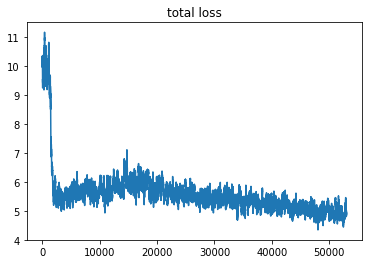

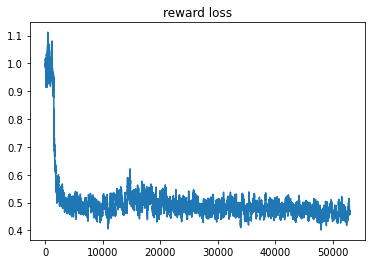

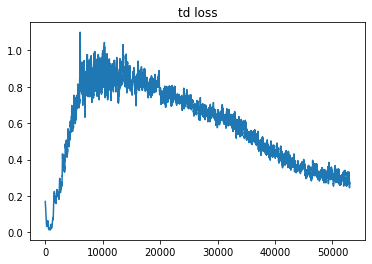

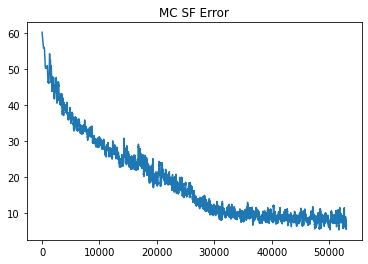

In [58]:
loss_labels = ['total loss', 'reward loss', 'td loss']
window = 100 // 2
for i, label in enumerate(loss_labels):
  plt.title(label)
  smoothed_loss = [np.mean(loss_hist[i][j-window:j+window]) \
    for j in range(window, len(loss_hist[i])-window)]
  plt.plot(smoothed_loss, label=label)
  plt.show()

plt.title('MC SF Error')
smoothed_error = [np.mean(mc_error_hist[j-window:j+window]) \
  for j in range(window, len(mc_error_hist)-window)]
plt.plot(smoothed_error, label='MC SF Error')
plt.show()

# Testing

In [125]:
def fit_skill_vector(skill_vector, batch_data, optimizer, model):
    device = next(model.parameters()).device

    batch_data = np.array(batch_data)
    obs, _, _, rewards, _, _ = \
      [torch.from_numpy(np.stack(batch_data[:, i])).to(device) \
      for i in range(batch_data.shape[1])]

    batch_svs = einops.repeat(skill_vector, 'e -> b e', b=obs.shape[0])
    batch_svs = batch_svs.to(device)
    with torch.no_grad():
      features, _ = model(obs, batch_svs)

    pred_rewards = torch.bmm(features.unsqueeze(1), batch_svs.unsqueeze(2))
    pred_rewards = pred_rewards.squeeze()

    residuals = (rewards - pred_rewards) ** 2
    loss = residuals.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [126]:
fit_steps = 500
ds_batch_size = 128
ds_print_freq = 50
test_episodes = 100

ds_lr = 1e-3

skill_vector = sample_skill()
skill_vector.requires_grad = True

env = explore_env

sv_optimizer = torch.optim.Adam((skill_vector,), lr=ds_lr)

sv_losses = []
for step_idx in range(fit_steps):
  batch_data = sample_batch(exp_buffer, ds_batch_size)
  if step_idx % 2 == 0:
    while not sum([x[3] for x in batch_data]):
      batch_data = sample_batch(exp_buffer, ds_batch_size)
    

  loss = fit_skill_vector(skill_vector, batch_data, sv_optimizer, model)
  sv_losses.append(loss)

  if step_idx != 0 and step_idx % ds_print_freq == 0:
    print('SV Reward Loss: {:.4f}'.format(np.mean(sv_losses[-ds_print_freq:])))

<ipython-input-125-c75b48d8f687>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_data = np.array(batch_data)


KeyboardInterrupt: 

In [59]:
test_rewards = []
test_hist = []
for episode_idx in tqdm(range(test_episodes)):
  obs = env.reset()
  test_hist.append([obs])

  ep_rewards = []
  done = False
  while not done:
    # Sample an action
    if np.random.rand() < end_act_epsilon:
      act = env.action_space.sample()
    else:
      with torch.no_grad():
        _, sfs = model(obs.unsqueeze(0).to(DEVICE),
                       skill_vector.unsqueeze(0).to(DEVICE))
      sfs = sfs.cpu()
      q_vals = torch.matmul(sfs[0], skill_vector.unsqueeze(1))
      act = torch.argmax(q_vals).item()

    # Make a step
    next_obs, reward, done, _ = env.step(act)
    reward = np.float32(reward)
    ep_rewards.append(reward)
    obs = next_obs
    test_hist[-1].append(obs)

  test_rewards.append(sum(ep_rewards))

print('Test Avg. Reward: {:.2f}'.format(np.mean(test_rewards)))

NameError: name 'test_episodes' is not defined

In [ ]:
plt.imshow(test_hist[23][30][0])

In [ ]:
batch_data = sample_batch(exp_buffer, ds_batch_size)

In [60]:
env = explore_env

In [61]:
obs_list = []
reward_list = []
map_pos_list = []
for i in range(1, map_shape[0]-1):
    for j in range(1, map_shape[1]-1):
        env.reset()
        obs, reward, done, _ = env.jump_to_state([i, j])
        obs_list.append(obs)
        reward_list.append(reward)
        map_pos_list.append([i, j])

In [62]:
# Least square fit to find skill vector
features, _ = model(torch.tensor(obs_list, dtype=torch.float32).to(DEVICE))
reward_matrix = torch.tensor(reward_list, dtype=torch.float32).unsqueeze(1).to(DEVICE)
# TODO: Normalize the skill vector
skill_vector = torch.linalg.lstsq(features, reward_matrix)[0]
skill_vector = skill_vector / torch.linalg.norm(skill_vector)
pred_rewards = torch.matmul(features, skill_vector)

In [63]:
reward_map = np.zeros(map_shape)
min_reward = min(pred_rewards.view(-1)).item()
for i in range(1, map_shape[0]-1):
    for j in range(1, map_shape[1]-1):
        reward_map[i, j] = pred_rewards[(j-1) + (i-1) * (map_shape[0]-2)].item() - min_reward

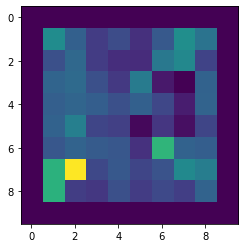

In [64]:
plt.imshow(reward_map)

In [77]:
# sorted(zip(map_pos_list, torch.matmul(features, skill_vector).squeeze()), reverse=True, key=lambda x: x[1])

In [70]:
fit_steps = 500
ds_batch_size = 128
ds_print_freq = 50
test_episodes = 100

test_rewards = []
test_hist = []
for episode_idx in tqdm(range(test_episodes)):
  obs = env.reset()
  test_hist.append([obs])

  ep_rewards = []
  done = False
  while not done:
    # Sample an action
    if np.random.rand() < end_act_epsilon:
      act = env.action_space.sample()
    else:
      with torch.no_grad():
        _, sfs = model(obs.unsqueeze(0).to(DEVICE),
                       skill_vector.squeeze().unsqueeze(0).to(DEVICE))
      sfs = sfs.cpu()
      q_vals = torch.matmul(sfs[0], skill_vector)
      act = torch.argmax(q_vals).item()

    # Make a step
    next_obs, reward, done, _ = env.step(act)
    reward = np.float32(reward)
    ep_rewards.append(reward)
    obs = next_obs
    test_hist[-1].append(obs)

  test_rewards.append(sum(ep_rewards))

print('Test Avg. Reward: {:.2f}'.format(np.mean(test_rewards)))

100%|██████████| 100/100 [00:01<00:00, 76.92it/s]

Test Avg. Reward: 0.17


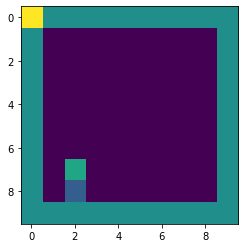

In [124]:
plt.imshow(test_hist[20][20][0])

In [ ]:
rc = 0
tc = 0

for i, sample in enumerate(exp_buffer):
    if sample[3] != 0:
        print(i)
        rc += 1
        break
    if sample[4]:
        tc += 1

rc, tc

In [ ]:
obs, act, next_obs, reward, terminal, sv = batch_data[0]

In [ ]:
reward, terminal

# Analysis Ideas

1. Look into why the TD loss starts to rise after seemingly settling
    - Does the behavior of the agent start changing?
2. Look at the state visitation distribution over time
3. Try decouipling the two learning vectors
4. See if we can predict a path given a the predicted successor features
    - Check the difference between actual predicted SFs and real ones (not a bootstrapped target)
5. Calculate the real SFs for the starts of several trajectories and look at the ranges
    - Are the ranges too large?
    - Would they be easier to predict if there was some sort of normalization?
6. Look into how the average length of episodes affects learning and losses
7. Look into how the stochastic termination affects learning and losses

In [ ]:
loss_labels = ['total loss', 'reward loss', 'td loss']
window = 100 // 2
for i, label in enumerate(loss_labels):
  plt.title(label)
  smoothed_loss = [np.mean(loss_hist[i][j-window:j+window]) \
    for j in range(window, len(loss_hist[i])-window)]
  plt.plot(smoothed_loss, label=label)
  plt.show()